In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import subprocess

In [34]:
# Anti-Shine-Dalgarno sequence (16S rRNA E. coli)
ANTI_SD_SEQ = "ACCUCCUUA"

def extract_number(line):
    """
    Extracts a number from a string provided by RNAFold in parenthesis.

    Args:
        line (str): The string to extract the number from.

    Returns:
        float: The extracted number, or None if not found.
    """
    match = re.search(r'\(\s*([-+]?[0-9]*\.?[0-9]+)\s*\)\s*$', line)
    return float(match.group(1)) if match else None


def compute_dG_SD_interaction(sd_candidate):
    """
    Compute the Gibbs free energy (ΔG) of SD-aSD interaction using RNAcofold.

    Returns:
        dG (float): The Gibbs free energy (ΔG) of SD-aSD interaction.
    """
    input_data = f"{sd_candidate}&{ANTI_SD_SEQ}"

    # Run RNAcofold
    result = subprocess.run(["RNAcofold", "−−noPS"], input=input_data, text=True, capture_output=True)
    output = result.stdout.strip().split("\n")

    # Get the numerical value from the parenthesis from the second line
    if len(output) > 1:
        dG = extract_number(output[1])
        return dG

    return None

## Import the cloud data

In [35]:
clouds = pd.read_csv('data/processed/clusters_with_stats.csv')
clouds.head()

,CLUSTER_,CORE REL EXPR_mean,CORE REL EXPR_std,SEQ_unique
0,0,0.129612,0.017409,"AATTTA,AATTCT,AATTCA,AACTTA,AAATCC,AATATG,AATA..."
1,1,0.229000,NaN,ATCCGC
2,2,0.123416,0.014622,"ACCTAC,ACCTCC,ACATCC,ACATCA,ACATAC,AAATCA,ATAT..."
3,3,0.052767,0.008386,"CGTTCC,CGTCCC,CGTCAC"
4,4,0.104843,0.013261,"CCGAAA,CCGAAT,CCGTGA,CTGCCT,CCGGAC,CAAGTC,CCGG..."


In [36]:
def mean_and_cv(comma_str):
    # split, score, drop any empty items
    items = [item for item in comma_str.split(',') if item]
    scores = [compute_dG_SD_interaction(item) for item in items]
    if not scores:
        return np.nan, np.nan
    m = np.mean(scores)
    sd = np.std(scores, ddof=0)   # population std; use ddof=1 for sample std
    cv = sd / m if m != 0 else 0
    return m, cv

clouds[['avg_free_energy', 'avg_cv']] = (
    clouds['SEQ_unique']
      .apply(lambda s: mean_and_cv(s))
      .apply(pd.Series)
)

clouds

,CLUSTER_,CORE REL EXPR_mean,CORE REL EXPR_std,SEQ_unique,avg_free_energy,avg_cv
0,0,0.129612,0.017409,"AATTTA,AATTCT,AATTCA,AACTTA,AAATCC,AATATG,AATA...",0.000000,0.000000
1,1,0.229000,NaN,ATCCGC,0.000000,0.000000
2,2,0.123416,0.014622,"ACCTAC,ACCTCC,ACATCC,ACATCA,ACATAC,AAATCA,ATAT...",-0.050746,-7.653843
3,3,0.052767,0.008386,"CGTTCC,CGTCCC,CGTCAC",0.000000,0.000000
4,4,0.104843,0.013261,"CCGAAA,CCGAAT,CCGTGA,CTGCCT,CCGGAC,CAAGTC,CCGG...",-0.821429,-1.642466
...,...,...,...,...,...,...
376,376,0.070700,0.018187,"CATCCG,TCACCG,TCCCCG",0.000000,0.000000
377,377,0.103400,0.011403,"ACTCGT,ACACCT,ACCTTT,ACATCT,CCCTAT,CCCCCT,CCAA...",-0.146512,-4.533073
378,378,0.081756,0.017708,"ACCAGT,ACCCAT,ATCCCT,AACAAT,CCCAAT,TCCCAT,GCCC...",-0.039706,-7.059516
379,379,0.130325,0.013597,"ACTAGT,CCAAGT,ATCAGT,CACAGT",-0.050000,-1.732051


In [37]:
# Check correlation between CORE REL EXPR_mean and avg_free_energy
clouds['CORE REL EXPR_mean'].corr(clouds['avg_free_energy'])

np.float64(-0.7786890806854008)

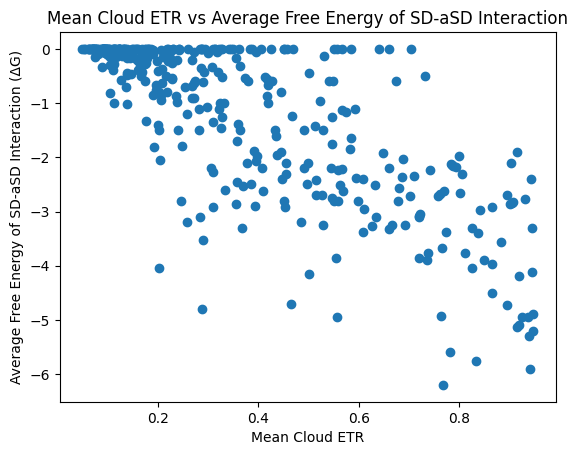

In [38]:
# Plot CORE REL EXPR_mean vs avg_free_energy
plt.scatter(clouds['CORE REL EXPR_mean'], clouds['avg_free_energy'])
plt.xlabel('Mean Cloud ETR')
plt.ylabel('Average Free Energy of SD-aSD Interaction (ΔG)')
plt.title('Mean Cloud ETR vs Average Free Energy of SD-aSD Interaction')
plt.show()

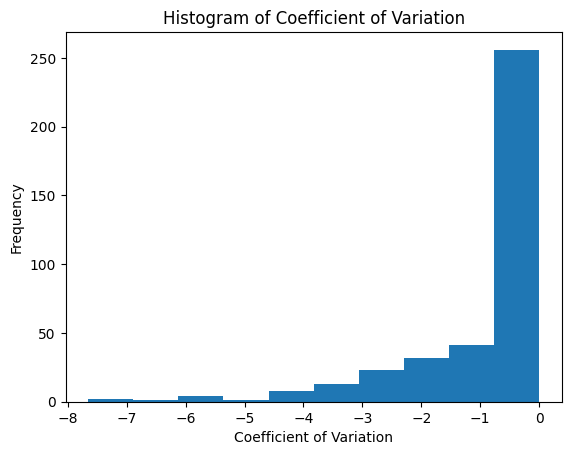

In [39]:
# Histogram of avg_cv
plt.hist(clouds['avg_cv'])
plt.xlabel('Coefficient of Variation')
plt.ylabel('Frequency')
plt.title('Histogram of Coefficient of Variation')
plt.show()

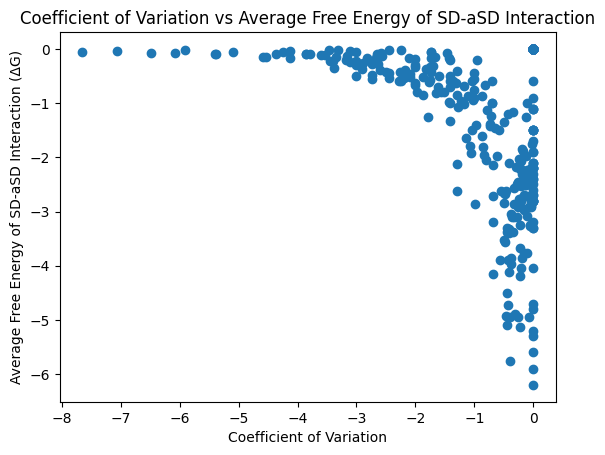

In [40]:
# Scatter plot of avg_cv vs avg_free_energy
plt.scatter(clouds['avg_cv'], clouds['avg_free_energy'])
plt.xlabel('Coefficient of Variation')
plt.ylabel('Average Free Energy of SD-aSD Interaction (ΔG)')
plt.title('Coefficient of Variation vs Average Free Energy of SD-aSD Interaction')
plt.show()